In [2]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy.units as u
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
import forecast
import emcee
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/mcmc_modules')
import unbinned_model as ub
from lnlikelihood import lnLikelihood
import pyccl as ccl
import edit
import h5py, glob
from astropy.coordinates import SkyCoord
from astropy.table import Table
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [4]:
mapping = ub.Mapping()

In [5]:
mapping.set_cosmology(cosmo)

In [32]:
z_grid = np.linspace(.2, 1, 500)
logm_grid = np.linspace(14., 15.6, 1020)
fsky_default = 1/2
fsky = fsky_default/3
fsky = 1
theta_aperture = np.arccos(1-2*fsky)*180/np.pi #deg

In [33]:
theta_aperture

180.0

In [34]:
dN_dlogmdz_map = mapping.compute_dN_dlogMdzdOmega_map(z_grid, logm_grid, fsky)
halo_bias_map = mapping.compute_halo_bias_map(z_grid, logm_grid)
sigma2_map = mapping.compute_sigma2_map(z_grid, fsky)

In [35]:
a = sigma2_map.flatten() == 0

In [36]:
len(a[a==True])

0

(array([2.46095e+05, 2.71700e+03, 6.20000e+02, 2.68000e+02, 1.39000e+02,
        7.20000e+01, 4.60000e+01, 2.80000e+01, 8.00000e+00, 7.00000e+00]),
 array([-7.27340165e-06,  5.97120665e-06,  1.92158149e-05,  3.24604232e-05,
         4.57050315e-05,  5.89496398e-05,  7.21942481e-05,  8.54388564e-05,
         9.86834647e-05,  1.11928073e-04,  1.25172681e-04]),
 <BarContainer object of 10 artists>)

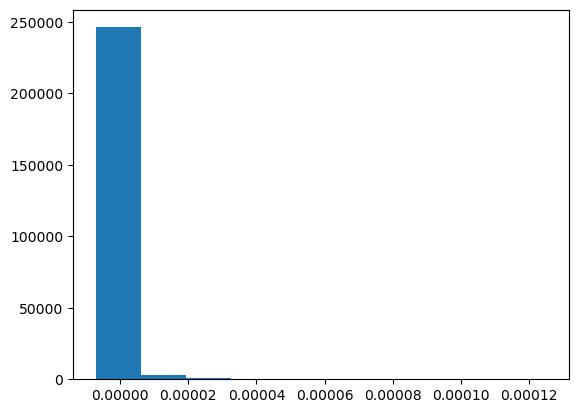

In [37]:
plt.hist(sigma2_map.flatten())

In [38]:
halo_bias_map.shape

(1020, 500)

In [39]:
s2 = np.diag(sigma2_map)

In [40]:
sigmab = np.zeros(halo_bias_map.shape)

In [41]:
for i in range(len(logm_grid)):
    sigmab[i,:] = halo_bias_map[i,:] * s2**.5

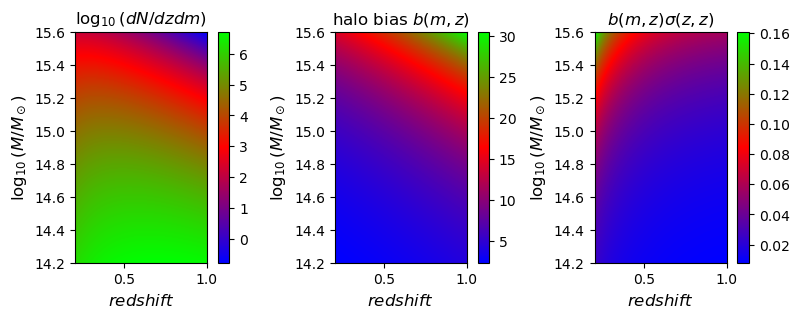

In [43]:
cmap = 'brg'
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(9.5,3))
plt.subplot(131)
plt.imshow(np.log10(dN_dlogmdz_map/fsky), cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(r'$\log_{10}(dN/dzdm)$')
plt.colorbar()
plt.xlabel(r'$redshift$', fontsize=12)
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.subplot(132)
plt.imshow(halo_bias_map, cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(r'halo bias $b(m,z)$')
plt.colorbar()
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.xlabel(r'$redshift$', fontsize=12)
plt.subplot(133)
plt.imshow(sigmab*fsky**.5, cmap=cmap, origin='lower', extent = (.2, 1, 14.2, 15.6))
plt.title(r'$b(m,z)\sigma(z,z)$')
plt.colorbar()
plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
plt.xlabel(r'$redshift$', fontsize=12)
#plt.ylabel(r'$\log_{10}(M/M_\odot)$', fontsize=12)
#plt.savefig('halobias.png', bbox_inches='tight', dpi=300)
plt.savefig('mapping.png', bbox_inches='tight', dpi=300)

In [15]:
0.16/0.25

0.64

In [16]:
indexz = 1
indexm = 499
err = np.sqrt(sigma2_map[indexz,indexz]) * halo_bias_map[indexz,indexm]

In [17]:
halo_bias_map[indexz,indexm]

4.269555161779236

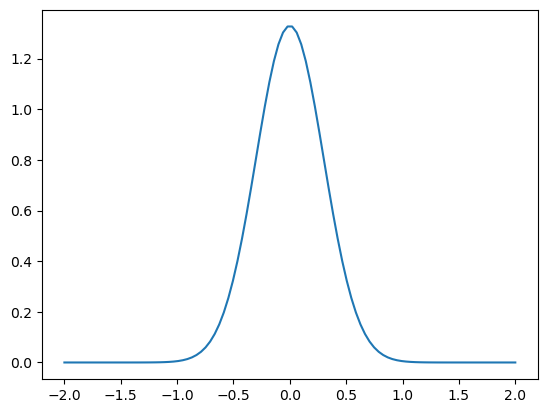

In [18]:
x = np.linspace(-2, 2, 100)
err=.3
y= np.exp(-(x)**2/(2*err**2))
plt.plot(x, y/np.trapz(y,x))

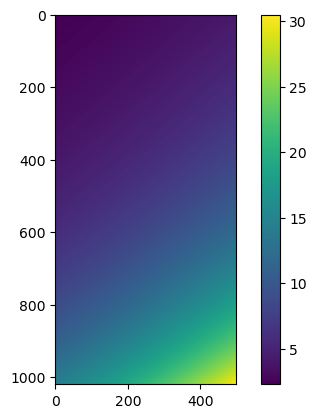

In [19]:
plt.imshow(halo_bias_map)
plt.colorbar()

In [20]:
mapping.interp(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, )

In [21]:
Nth = mapping.compute_N_th(z_grid, logm_grid, dN_dlogmdz_map)

In [22]:
Nth

203754.1180680988

In [23]:
NNSbb_thth = mapping.compute_NNSbb_thth(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, Nth)

In [24]:
NNSbb_thth

152905.15223649543

# Data

In [25]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)
cat_test = pd.read_csv(cat[35] ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
#select in aperture
#ra_center, dec_center = 180, 60
#cat_center_SkyCoord =SkyCoord(ra=np.array([ra_center])*u.degree, dec=np.array([dec_center])*u.degree)
#pos_ra, pos_dec = cat_test['ra'], cat_test['dec']
#cat_pinocchio_SkyCoord=SkyCoord(ra=np.array(pos_ra)*u.degree, dec=np.array(pos_dec)*u.degree)
#idxcat_center, idxcat_pinocchio, d2d, d3d = cat_center_SkyCoord.search_around_sky(cat_pinocchio_SkyCoord, theta_aperture*u.deg)
#resize catalog
#cat_test = Table.from_pandas(cat_test)[idxcat_center]
#raa, decc, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777

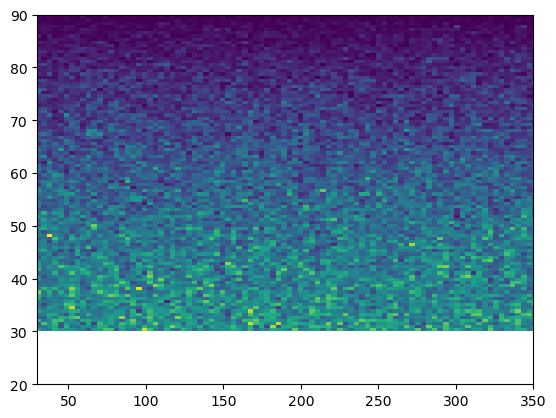

In [26]:
plt.hist2d(ra, dec,bins=100)
#plt.hist2d(raa, decc,bins=100, cmap = 'bwr', cmin=1)
plt.xlim(30, 350)
plt.ylim(20, 90)
plt.show()

In [155]:
mask = (redshift > .2)&(redshift < .3)
mask = mask &(np.log10(Mvir) > 14.3)&(np.log10(Mvir) < 14.4)
redshift_cut = redshift[mask]
Mvir_cut = Mvir[mask]

In [156]:
Nobs = len(Mvir_cut)

In [157]:
Nobs

1638

In [158]:
z_sample = redshift_cut
logm_sample = np.log10(Mvir_cut)

In [159]:
#mapping.create_reduced_sample( z_sample, logm_sample, n_samples =2000)
NNSbb_obsobs = mapping.compute_NNSbb_obsobs(z_grid, logm_grid, 
                                        sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                        z_sample, logm_sample, Nobs, reduced_sample = False)

In [160]:
NNSbb_obsobs

805.970705732777

In [161]:
#mapping.create_reduced_sample( z_sample, logm_sample, n_samples =5000)
NNSbb_obsth = mapping.compute_NNSbb_obsth(z_grid, logm_grid, 
                                      sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                                      z_sample, logm_sample, Nth, Nobs, reduced_sample = False)

In [162]:
NNSbb_obsth 

3253.62749631998

In [ ]:
NSb2_obs = mapping.compute_NSb2_obs(z_grid, logm_grid, sigma2_map, dN_dlogmdz_map, halo_bias_map, 
                            z_sample, logm_sample, Nth, Nobs, reduced_sample = False)

In [ ]:
NSb2_obs/2

In [ ]:
dN_dzdlogM = mapping.N_map_interp_fct(logm_sample, z_sample, grid = False)

In [ ]:
import unbinned_likelihood

In [ ]:
r = unbinned_likelihood.lnLikelihood_UnBinned_Poissonian_SSC(dN_dzdlogM, Nth, Nobs,
                                     NNSbb_obsobs,
                                     NNSbb_obsth,
                                     NNSbb_thth,
                                     NSb2_obs)

In [ ]:
r

In [ ]:
r = unbinned_likelihood.lnLikelihood_UnBinned_Poissonian(dN_dzdlogM, Nth,
                                     )

In [ ]:
r